In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, GlobalAveragePooling2D, Dense, Add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# Model Architecture
def build_uniscriptnet(input_shape=(32, 32, 1), num_classes=84):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Block
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Residual Block 1
    shortcut = x
    x = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(shortcut)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Residual Block 2
    shortcut = x
    x = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(128, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(shortcut)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    # Residual Block 3
    shortcut = x
    x = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(256, (1, 1), padding='same', kernel_regularizer=l2(1e-4))(shortcut)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Fully Connected Layer
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Cosine Annealing Learning Rate Schedule
def cosine_annealing_schedule(epoch, max_lr=1e-3, min_lr=1e-5, T_max=15):
    t = epoch % T_max
    lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * t / T_max))
    return lr

# Label Smoothing Loss
def categorical_crossentropy_with_label_smoothing(y_true, y_pred, label_smoothing=0.05):
    y_true = y_true * (1.0 - label_smoothing) + (label_smoothing / K.cast(K.shape(y_true)[-1], K.floatx()))
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

print("Model Initialized!")

2025-06-09 20:51:43.266631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749502303.434744      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749502303.485244      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model Initialized!


In [2]:
# Data Loading
dataset_path = "/kaggle/input/bangla-lekha-isolated-dataset/BanglaLekha-Isolated/Images"
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
epochs = 100
num_classes = 84

# Training Data Augmentation (Milder)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    shear_range=0.05,
    horizontal_flip=False,
    validation_split=0.2
)

# Validation Data (No Augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training',
    shuffle=True,
    seed=33
)

val_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    seed=33
)

# Check Class Distribution
print("Training class distribution:", Counter(train_generator.classes))
print("Validation class distribution:", Counter(val_generator.classes))

Found 132914 images belonging to 84 classes.
Found 33191 images belonging to 84 classes.
Training class distribution: Counter({20: 1591, 55: 1589, 7: 1588, 8: 1588, 11: 1588, 31: 1588, 36: 1588, 37: 1588, 43: 1588, 58: 1588, 63: 1588, 68: 1588, 69: 1588, 72: 1588, 73: 1588, 13: 1587, 16: 1587, 23: 1587, 30: 1587, 33: 1587, 35: 1587, 47: 1587, 66: 1587, 3: 1586, 4: 1586, 5: 1586, 10: 1586, 19: 1586, 32: 1586, 50: 1586, 51: 1586, 67: 1586, 75: 1586, 9: 1585, 17: 1585, 28: 1585, 41: 1585, 48: 1585, 49: 1585, 56: 1585, 60: 1585, 77: 1585, 1: 1584, 2: 1584, 15: 1584, 18: 1584, 25: 1584, 34: 1584, 39: 1584, 42: 1584, 45: 1584, 46: 1584, 54: 1584, 61: 1584, 79: 1584, 64: 1583, 65: 1583, 81: 1583, 21: 1582, 24: 1582, 27: 1582, 78: 1582, 0: 1580, 14: 1580, 26: 1580, 53: 1580, 80: 1580, 40: 1578, 6: 1577, 82: 1577, 12: 1576, 38: 1576, 44: 1576, 29: 1575, 71: 1575, 59: 1574, 70: 1573, 83: 1573, 74: 1572, 57: 1567, 52: 1563, 62: 1563, 22: 1553, 76: 1552})
Validation class distribution: Counter({7:

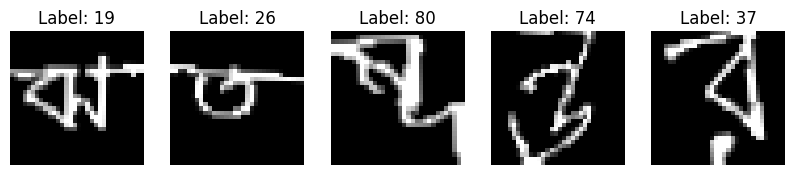

In [3]:
# Visualize Augmented Images
batch = next(train_generator)
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0][i].reshape(32, 32), cmap='gray')
    plt.title(f"Label: {np.argmax(batch[1][i])}")
    plt.axis('off')
plt.show()

# Compute Class Weights (Optional)
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

In [4]:
# Compile and Train
model = build_uniscriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=categorical_crossentropy_with_label_smoothing,
              metrics=['accuracy'])

model.summary()

I0000 00:00:1749502449.049194      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749502449.049873      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 32)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 16, 16, 32)     │            320 │ dropout[0][0]          │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 32)     │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 16, 16, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │          2,112 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 64)     │          2,112 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 64)     │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8, 8, 64)       │              0 │ max_pooling2d_1[0][0]  │
├──────────────────────

 Total params: 269,012 (1.03 MB)

 Trainable params: 266,580 (1.02 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [5]:
#Callbacks
callbacks = [
    LearningRateScheduler(cosine_annealing_schedule),
    EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("uniscriptnet_banglalekha_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

#Train model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict  # Optional: Enable if class imbalance detected
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1749502476.585766     110 service.cc:148] XLA service 0x7d08ec0051f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749502476.586498     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749502476.586521     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749502477.660066     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2077 ━━━━━━━━━━━━━━━━━━━━ 10:41:47 19s/step - accuracy: 0.0000e+00 - loss: 5.6042

I0000 00:00:1749502485.469535     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.1491 - loss: 3.9244
Epoch 1: val_accuracy improved from -inf to 0.74650, saving model to uniscriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 1264s 600ms/step - accuracy: 0.1492 - loss: 3.9239 - val_accuracy: 0.7465 - val_loss: 1.4373 - learning_rate: 0.0010
Epoch 2/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5805 - loss: 1.9413
Epoch 2: val_accuracy improved from 0.74650 to 0.83607, saving model to uniscriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 368s 177ms/step - accuracy: 0.5805 - loss: 1.9412 - val_accuracy: 0.8361 - val_loss: 1.1686 - learning_rate: 9.8918e-04
Epoch 3/100
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6651 - loss: 1.6770
Epoch 3: val_accuracy improved from 0.83607 to 0.86270, saving model to uniscriptnet_banglalekha_best.h5
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 241s 116ms/step - accuracy: 0.6651 - loss: 1.6770 - val_accuracy: 0.8627 - val_loss: 1.1132 - lea

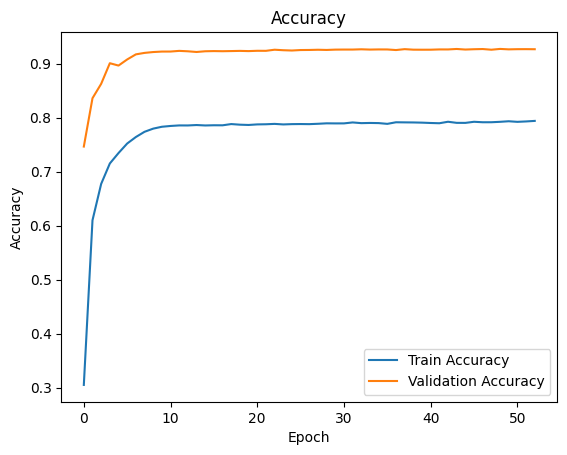

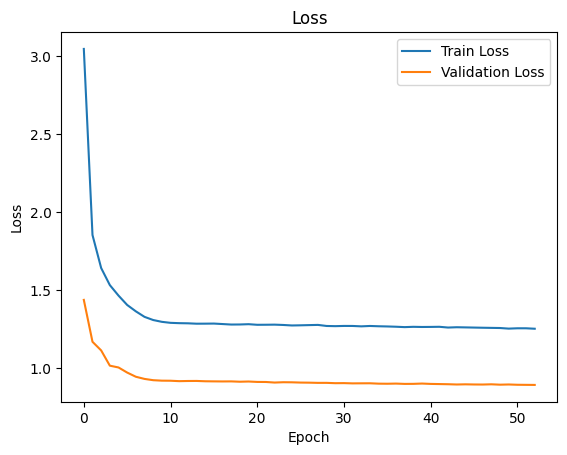

519/519 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.9323 - loss: 0.8948
Final Validation Accuracy: 92.69%


In [6]:
# Visualize Training Metrics
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on Validation Set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Final Validation Accuracy: {val_accuracy*100:.2f}%")

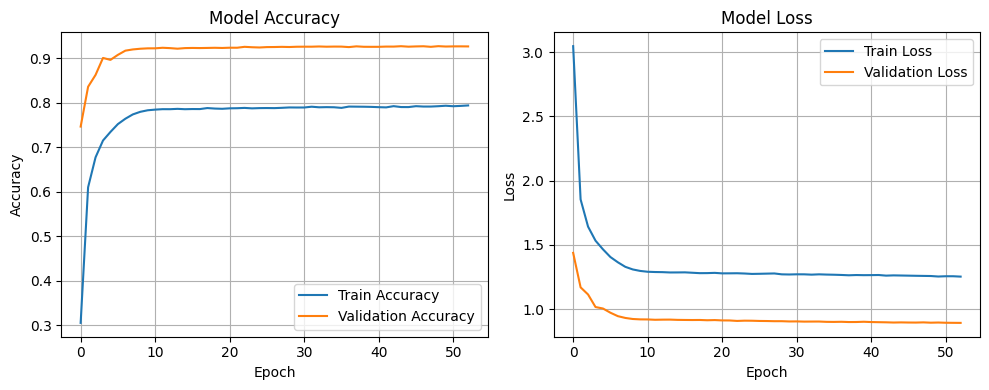

In [8]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")


519/519 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step
📋 Classification Report:

              precision    recall  f1-score   support

          01     0.9249    0.9671    0.9455       395
          02     0.9151    0.9798    0.9463       396
          03     0.9731    0.9165    0.9439       395
          04     0.9108    0.9798    0.9440       396
          05     0.9333    0.8838    0.9079       396
          06     0.8928    0.9672    0.9285       396
          07     0.9557    0.9848    0.9700       394
          08     0.9839    0.9244    0.9532       397
          09     0.9840    0.9318    0.9572       396
          10     0.9437    0.8460    0.8921       396
          11     0.9353    0.9848    0.9594       396
          12     0.9769    0.9621    0.9695       396
          13     0.9153    0.8244    0.8675       393
          14     0.9573    0.9066    0.9313       396
          15     0.9182    0.8810    0.8992       395
          16     0.9133    0.9571    0.9346       396
          17